In [115]:
import time
import pandas as pd
import numpy as np
from copy import deepcopy
import sys
import os
import csv
from itertools import cycle
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")
# warnings.resetwarnings() # To change it back (optional)

sys.path.append("/nobackup/gogandhi/alt_means_sans_k/")

from scripts.similarity_scores import *
from scripts.nets_and_embeddings import *

In [116]:
# Does changing tau2 with a fixed tau1 
# make the community distribution better for our method to 
# get communities better than kmeans?

params = {
    "N": 10000,
    "k": 50,
    "maxk": 1000,
    "minc": 50,
    "maxc": 1200, #maxc > maxk and minc > mink has to be satisfied.
    "tau": 3.0,
    "tau2": 2.0,
    "mu": 0.20,
}

emb_params = {
    "method": "node2vec",
    "window_length": 10,
    "walk_length": 80,
    "num_walks": 10,
    "dim": 64,
}

score_keys = ['kmeans', 'xmeans', 'infomap','proposed']
device_name="cuda:3"

In [117]:
params['tau2'] = 1.0
net, community_table, emb = create_and_save_network_and_embedding(params, emb_params, None, False)

params['tau2'] = 1.5
net1, community_table1, emb1 = create_and_save_network_and_embedding(params, emb_params, None, False)

params['tau2'] = 2.0
net2, community_table2, emb2 = create_and_save_network_and_embedding(params, emb_params, None, False)

In [118]:
def proposed_method_labels(emb,device_name):
    rpos, cpos, vpos = find_knn_edges(emb, num_neighbors=100, device = device_name)
    cneg = np.random.choice(emb.shape[0], len(cpos))
    vneg = np.array(np.sum(emb[rpos, :] * emb[cneg, :], axis=1)).reshape(-1)

    model = LogisticRegression()
    model.fit(
        np.concatenate([vpos, vneg]).reshape((-1, 1)),
        np.concatenate([np.ones_like(vpos), np.zeros_like(vneg)]),
            )
    w1, b0 = model.coef_[0, 0], -model.intercept_[0] 
    return louvain(emb, w1, b0, device = device_name)

proposed_labels = proposed_method_labels(emb,device_name)
proposed_labels1 = proposed_method_labels(emb1,device_name)
proposed_labels2 = proposed_method_labels(emb2,device_name)

print(calc_esim(community_table["community_id"], proposed_labels), " : proposed | 1.0")
print(calc_esim(community_table1["community_id"], proposed_labels1), " : proposed | 1.5")
print(calc_esim(community_table2["community_id"], proposed_labels2), " : proposed | 2.0")



#X = np.einsum("ij,i->ij", emb, 1 / np.maximum(np.linalg.norm(emb, axis=1), 1e-24))
X = emb.copy()
kmeans = KMeans(n_clusters= len(set(community_table["community_id"])), random_state=0).fit(X)

#X = np.einsum("ij,i->ij", emb1, 1 / np.maximum(np.linalg.norm(emb, axis=1), 1e-24))
X = emb1.copy()
kmeans1 = KMeans(n_clusters= len(set(community_table1["community_id"])), random_state=0).fit(X)

#X = np.einsum("ij,i->ij", emb2, 1 / np.maximum(np.linalg.norm(emb, axis=1), 1e-24))
X = emb2.copy()
kmeans2 = KMeans(n_clusters= len(set(community_table2["community_id"])), random_state=0).fit(X)


print(calc_esim(community_table["community_id"], kmeans.labels_), " : Kmeans | 1.0")
print(calc_esim(community_table1["community_id"], kmeans1.labels_), " : Kmeans | 1.5")
print(calc_esim(community_table2["community_id"], kmeans2.labels_), " : Kmeans | 2.0")

0.8727484545379893  : proposed | 1.0
0.8699143835541211  : proposed | 1.5
0.8907793645709837  : proposed | 2.0
1.0  : Kmeans | 1.0
0.9454439435934419  : Kmeans | 1.5
0.9564170371708615  : Kmeans | 2.0


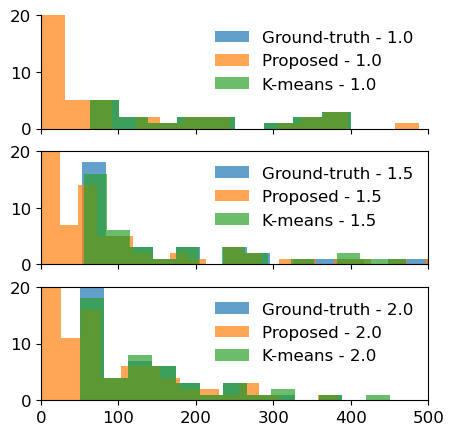

In [136]:
import numpy as np
import matplotlib.pyplot as plt

bins = 30 

clus_sz = np.unique(community_table['community_id'], return_counts=True)[1]
clus_sz_1 = np.unique(community_table1['community_id'], return_counts=True)[1]
clus_sz_2 = np.unique(community_table2['community_id'], return_counts=True)[1]

clus_sz_kmeans = np.unique(kmeans.labels_, return_counts=True)[1]
clus_sz_kmeans1 = np.unique(kmeans1.labels_, return_counts=True)[1]
clus_sz_kmeans2 = np.unique(kmeans2.labels_, return_counts=True)[1]
clus_sz_proposed = np.unique(proposed_labels, return_counts=True)[1]
clus_sz_proposed1 = np.unique(proposed_labels1, return_counts=True)[1]
clus_sz_proposed2 = np.unique(proposed_labels2, return_counts=True)[1]

plt.rcParams.update({'font.size': 12})

fig, ax = plt.subplots(3,1,figsize=(5, 5),sharex=True, sharey=True)

ax[0].hist(clus_sz, bins = bins, label="Ground-truth - 1.0", alpha=0.7)
ax[0].hist(clus_sz_proposed, bins=bins, label="Proposed - 1.0", alpha=0.7)
ax[0].hist(clus_sz_kmeans, bins=bins, label="K-means - 1.0", alpha=0.7)

ax[1].hist(clus_sz_1, bins=bins, label="Ground-truth - 1.5", alpha=0.7     )
ax[1].hist(clus_sz_proposed1, bins=bins, label="Proposed - 1.5", alpha=0.7)
ax[1].hist(clus_sz_kmeans1, bins=bins, label="K-means - 1.5", alpha=0.7)

ax[2].hist(clus_sz_2, bins=bins, label="Ground-truth - 2.0", alpha=0.7)
ax[2].hist(clus_sz_proposed2, bins=bins, label="Proposed - 2.0", alpha=0.7)
ax[2].hist(clus_sz_kmeans2, bins=bins, label="K-means - 2.0", alpha=0.7)

ax[0].set_ylim(0,20)
ax[0].set_xlim(0,500)
ax[0].legend(frameon=False)
ax[1].legend(frameon=False)
ax[2].legend(frameon=False)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)

plt.show()


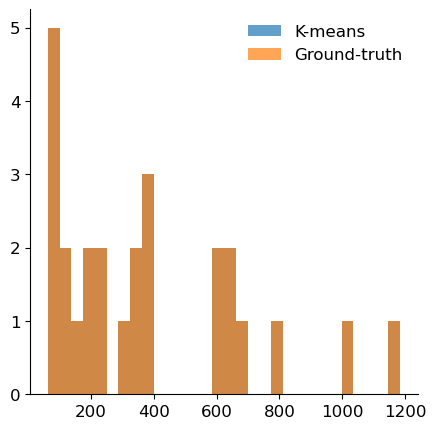

Earth Mover's Distance: 0.0


In [123]:
import numpy as np
from scipy.stats import wasserstein_distance
import matplotlib.pyplot as plt

# Assuming clus_sz and clus_sz_kmeans are already defined

# Plotting the histograms (optional)
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(figsize=(5, 5))
ax.hist(clus_sz_kmeans, bins=30, label="K-means", alpha=0.7)
ax.hist(clus_sz, bins=30, color='C1', label="Ground-truth", alpha=0.7)
ax.legend(frameon=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

# Calculate Earth Mover's Distance
emd_distance = wasserstein_distance(clus_sz, clus_sz_kmeans)

print(f"Earth Mover's Distance: {emd_distance}")
